#  ATLAS/ICESat-2 Monthly Gridded Sea Ice Freeboard
*Introduce dataset here*

# 1) Read data

## Set desired date range 
Our analysis looks at winter data, so we'll only load data for the Northern Hemisphere's winter season (Nov-Apr)

In [1]:
import os
import xarray as xr
import numpy as np
import pandas as pd

# Remove warnings to improve display
import warnings 
warnings.filterwarnings('ignore')

# Import utils 
from utils.misc_utils import restrictRegionally, is2_interp2d, getWinterDateRange
from utils.read_data_utils import read_is2_data, read_book_data
from utils.plotting_utils import plot_winter_means, arcticComparisonMaps

# Plotting
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
from textwrap import wrap
import matplotlib as mpl
import matplotlib.pyplot as plt

GeoAxes._pcolormesh_patched = Axes.pcolormesh
%config InlineBackend.figure_format = 'retina'
mpl.rcParams['figure.dpi'] = 100

In [2]:
winter18_19 = pd.date_range(start="2018-11-01", end="2019-04-01", freq="MS")
winter19_20 = pd.date_range(start="2019-09-01", end="2020-04-01", freq="MS")
winter20_21 = pd.date_range(start="2020-09-01", end="2021-04-01", freq="MS") # We don't have cdr data for 2021 yet
winter_months = winter18_19.append(winter19_20).append(winter20_21)
print(winter_months)

DatetimeIndex(['2018-11-01', '2018-12-01', '2019-01-01', '2019-02-01',
               '2019-03-01', '2019-04-01', '2019-09-01', '2019-10-01',
               '2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01',
               '2020-03-01', '2020-04-01', '2020-09-01', '2020-10-01',
               '2020-11-01', '2020-12-01', '2021-01-01', '2021-02-01',
               '2021-03-01', '2021-04-01'],
              dtype='datetime64[ns]', freq=None)


## Read in ICESat-2 data 
If the data doesn't already exist in the user's local drive, the function read_is2_data will download the files from the google storage bucket.

In [3]:
is2_ds = read_is2_data() # Read in data
is2_ds = is2_ds.sel(time=winter_months) # Get winter months
print(is2_ds)

<xarray.Dataset>
Dimensions:            (time: 22, x: 304, y: 448)
Coordinates:
    longitude          (y, x) float32 dask.array<chunksize=(448, 304), meta=np.ndarray>
    latitude           (y, x) float32 dask.array<chunksize=(448, 304), meta=np.ndarray>
    xgrid              (y, x) float32 dask.array<chunksize=(448, 304), meta=np.ndarray>
    ygrid              (y, x) float32 dask.array<chunksize=(448, 304), meta=np.ndarray>
  * time               (time) datetime64[ns] 2018-11-01 ... 2021-04-01
Dimensions without coordinates: x, y
Data variables:
    projection         (time) int32 -2147483647 -2147483647 ... -2147483647
    ice_thickness      (time, y, x) float32 dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
    ice_thickness_unc  (time, y, x) float32 dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
    num_segments       (time, y, x) float32 dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
    mean_day_of_month  (time, y, x) float32 dask.array<chunksize=(1, 448, 304

## Set interpolation preferences  
The dataset included uninterpolated data, or we can interpolate the data using a simple nearest neighbor interpolation function. Because ICESat-2 doesn't provide full monthly coverage, interpolating fills missing grid cells with a best guess based on surrounding data. This helps avoid sampling biases when performing time series analyses, with the cavaet that this interpolation method is subjective. <br><br>
In order to definte the interpolation bounds (so that we don't try and interpolate over land, or other areas where there wouldn't be sea ice!), we use the [NOAA/NSIDC Climate Data Record of Passive Microwave Sea Ice Concentration](https://nsidc.org/data/g02202) dataset to infer the location of the sea ice. By setting interpolation=True, the code calls an interpolation function that is defined in the `misc_utils.py` module.

In [4]:
# Set to false now because CDR data was not available at the time of writing this code chunk (Aug 2021)
interpolate = True # Do NOT interpolate. Set to TRUE to interpolate

if (interpolate == True): 
    # Get CDR data
    cdr_da = read_book_data()["cdr_seaice_conc_monthly"] 
    
    # Restrict time range. CDR data not yet available for 2021
    winter_months = [date for date in winter_months if "2021" not in str(date.year)] 
    cdr_da = cdr_da.sel(time=winter_months) # Get winter months
    is2_ds = is2_ds.sel(time=winter_months)
    
    # Perform interpolation
    is2_ds = is2_interp2d(is2_ds, cdr_da, method='nearest', interp_var='all')

# 2) Map mean winter ice thickness
Using the cartopy mapping package for python, we overlay mean ice thickness for each winter season on a basemap of the Arctic.

In [5]:
def plotArcticOneMonth(da, minval=None, maxval=None, title=None, cmap='viridis', show_mean=True): 
    """Plots map of the arctic on North Pole Stereo projection with one month of data overlayed, along with the sea ice edge for each month.
    Cartopy has a bug and cannot produce a contour plot on a rotated grid. Here we use a workaround from stackexchange: https://stackoverflow.com/questions/55062406/cartopy-fails-to-correctly-contour-data-on-rotated-grid
   
    Args:
        da (xr DataArray): data to plot
        minval, maxval (int, optional): minimum and maximum values for the data variable (default to xarray default)
        cmap (str, optional): color map (default to viridis)
        title (str, optional): title of subplots (default to empty string)
        show_mean (bool, optional): add mean value to plot (default to True)
        
    Returns:
        Figure displayed in notebook 
    
    """
    # Plot the data
    fig = plt.figure(figsize=(6,6))
    ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-45))
    da.plot(x='longitude', y='latitude', vmin=minval, vmax=maxval, extend='both', 
            ax=ax, add_colorbar=True, transform=ccrs.PlateCarree(), zorder=2, cmap=cmap, 
            cbar_kwargs = {'orientation': 'horizontal', 'shrink': 0.75, 'pad': 0.025})
    
    # Add features to the map
    ax.coastlines(linewidth=0.15, color = 'black', zorder = 10) # Coastlines
    ax.add_feature(cfeature.LAND, color ='0.95', zorder = 5)    # Land
    ax.add_feature(cfeature.LAKES, color = 'grey', zorder = 5)  # Lakes
    ax.gridlines(draw_labels=False, linewidth=0.25, color='gray', alpha=0.7, linestyle='--', zorder=6) # Gridlines
    ax.set_extent([-179, 179, 50, 90], crs=ccrs.PlateCarree()) # Set extent to zoom in on Arctic
    
    if title is not None: # Set title
        ax.set_title("\n".join(wrap(title, 40)), fontsize=13, y=1, fontweight='medium')
    
    if show_mean: # Compute and show mean value 
        mean_val = round(da.mean().values.item(),2)
        ax.text(x = 0.68, y = 0.97, s = "mean val: " + str(mean_val), zorder=20, horizontalalignment='left', verticalalignment='top', fontsize=10, transform=ax.transAxes, bbox={'facecolor':'white','edgecolor':'lightgrey','boxstyle':'round'})
    
    plt.show()

In [6]:
thickness = is2_ds["ice_thickness"]

## Winter 2018-19

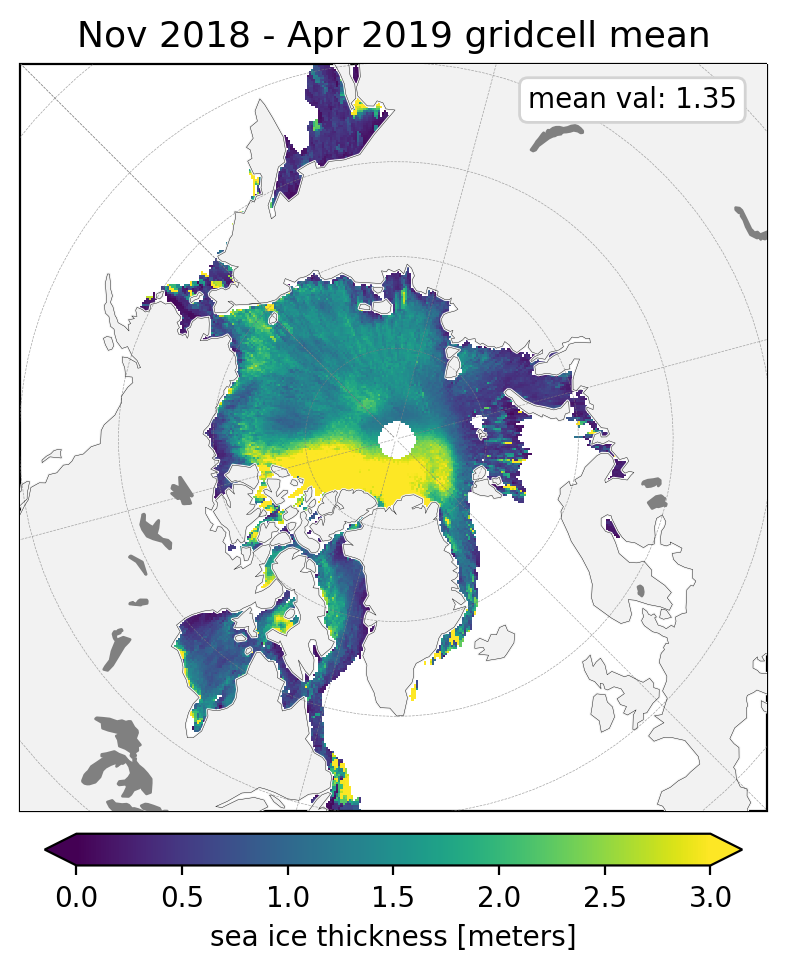

In [21]:
# Compute mean thickness for winter 1 (Nov 2018 - Apr 2019)
thickness_av_winter1 = thickness.sel(time=slice("Nov 2018", "Apr 2019")).mean(dim = ["time"])
thickness_av_winter1 = thickness_av_winter1.assign_attrs(thickness.attrs)

# Plot
plotArcticOneMonth(thickness_av_winter1, minval=0, maxval=3, title="Nov 2018 - Apr 2019 gridcell mean")

## Winter 2019-20

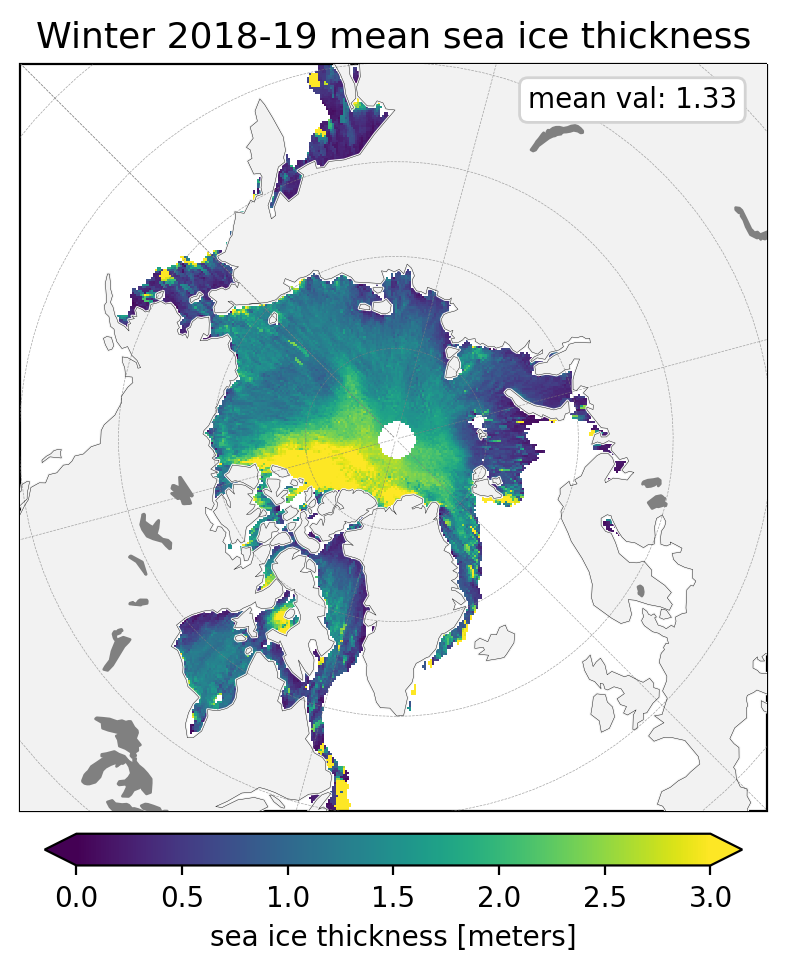

In [8]:
# Compute mean thickness for winter 2 (Nov 2019 - Apr 2020)
thickness_av_winter2 = thickness.sel(time=slice("Nov 2019", "Apr 2020")).mean(dim = ["time"])
thickness_av_winter2 = thickness_av_winter2.assign_attrs(thickness.attrs)

# Plot
plotArcticOneMonth(thickness_av_winter2, minval=0, maxval=3, title="Nov 2019 - Apr 2020 gridcell mean")

## Winter 2020-21

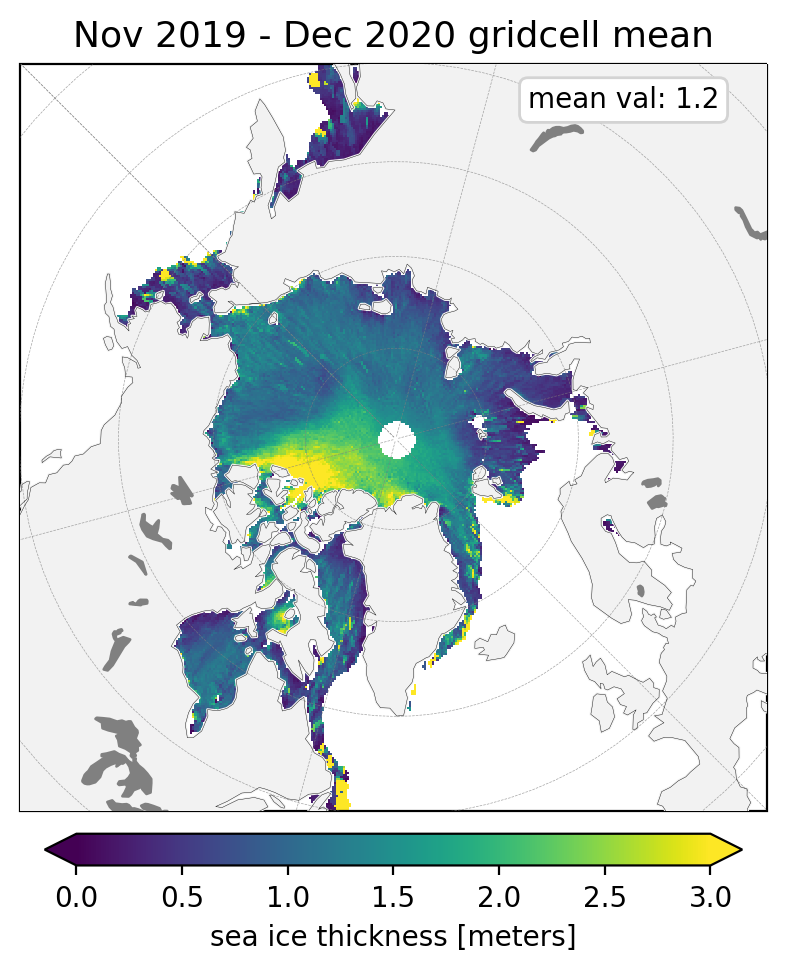

In [20]:
# Compute mean thickness for winter 3
end_month = winter_months[-1].strftime("%b ")+winter_months[-1].strftime("%Y") # Need to be a bit fancy here so that it works for interpolated data (which cuts off at Dec 2020) and uninterpolated data (which allows the entire winter of data, since it's not dependent on the CDR data)
thickness_av_winter2 = thickness.sel(time=slice("Nov 2019", end_month)).mean(dim = ["time"])
thickness_av_winter2 = thickness_av_winter2.assign_attrs(thickness.attrs)

# Plot
plotArcticOneMonth(thickness_av_winter2, minval=0, maxval=3, title="Nov 2019 - "+end_month+" gridcell mean")

# 3) Generate a simple line plot of mean ice thickness over time
We'll also show the mean uncertainty associated with the ice thickness measurements. This is provided as a variable in the monthly gridded dataset. 

## 3a) See all winters together 
So far, we have 3 full winters of data. ICESat-2 began collecting in November of 2018, so the winter season for 2018-2019 will not show data for September or October. 

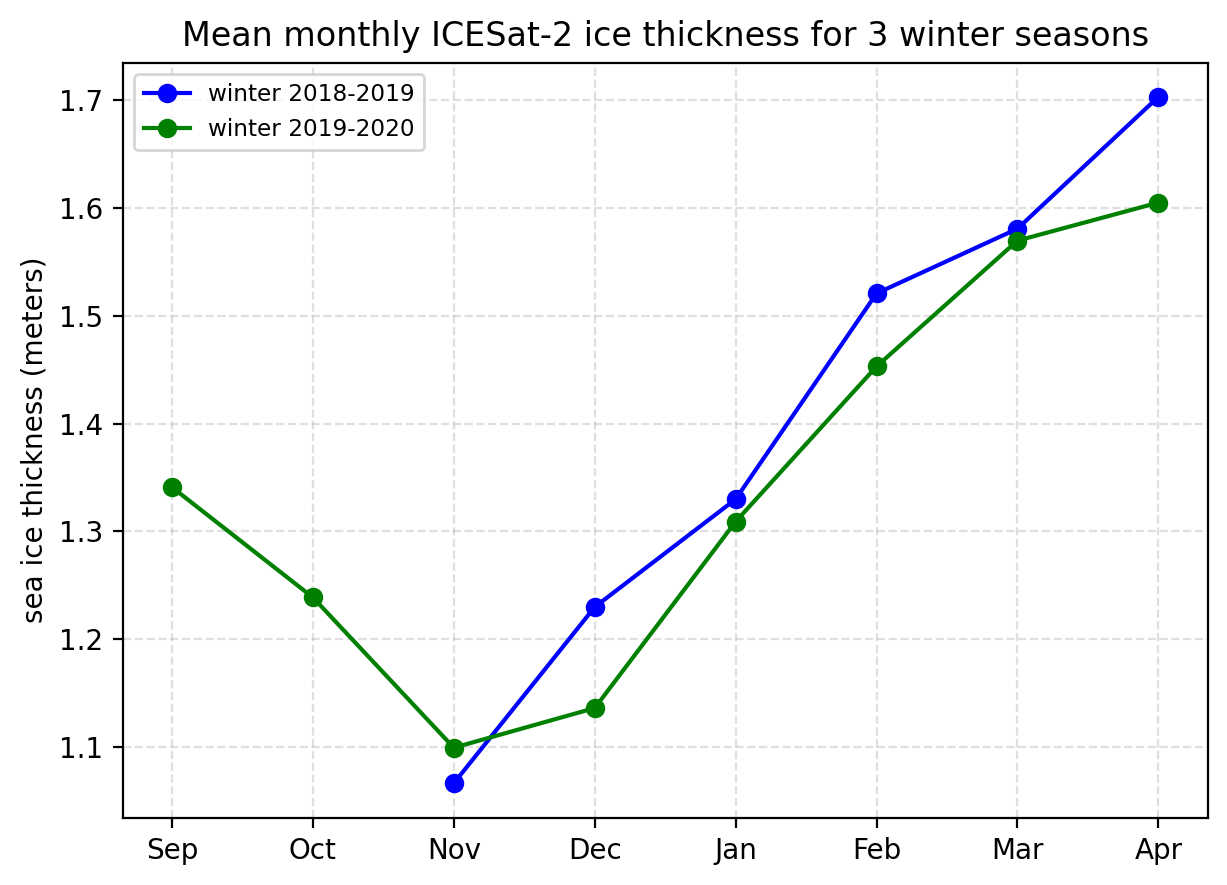

In [9]:
start_year = str(winter_months[0].year) 
end_year = str(winter_months[-1].year)
plot_winter_means(da=thickness, start_year=start_year, end_year=end_year, 
                  show_uncertainty=False, 
                  title="Mean monthly ICESat-2 ice thickness for 3 winter seasons") 

## 3b) Most recent winter of data (winter 2020-2021)
Here, we'll also plot the uncertainty associated with the thickness measurements. The plotting function computes mean monthly sea ice thickness uncertainty and displays it as shading around the line of mean monthly ice thickness. 

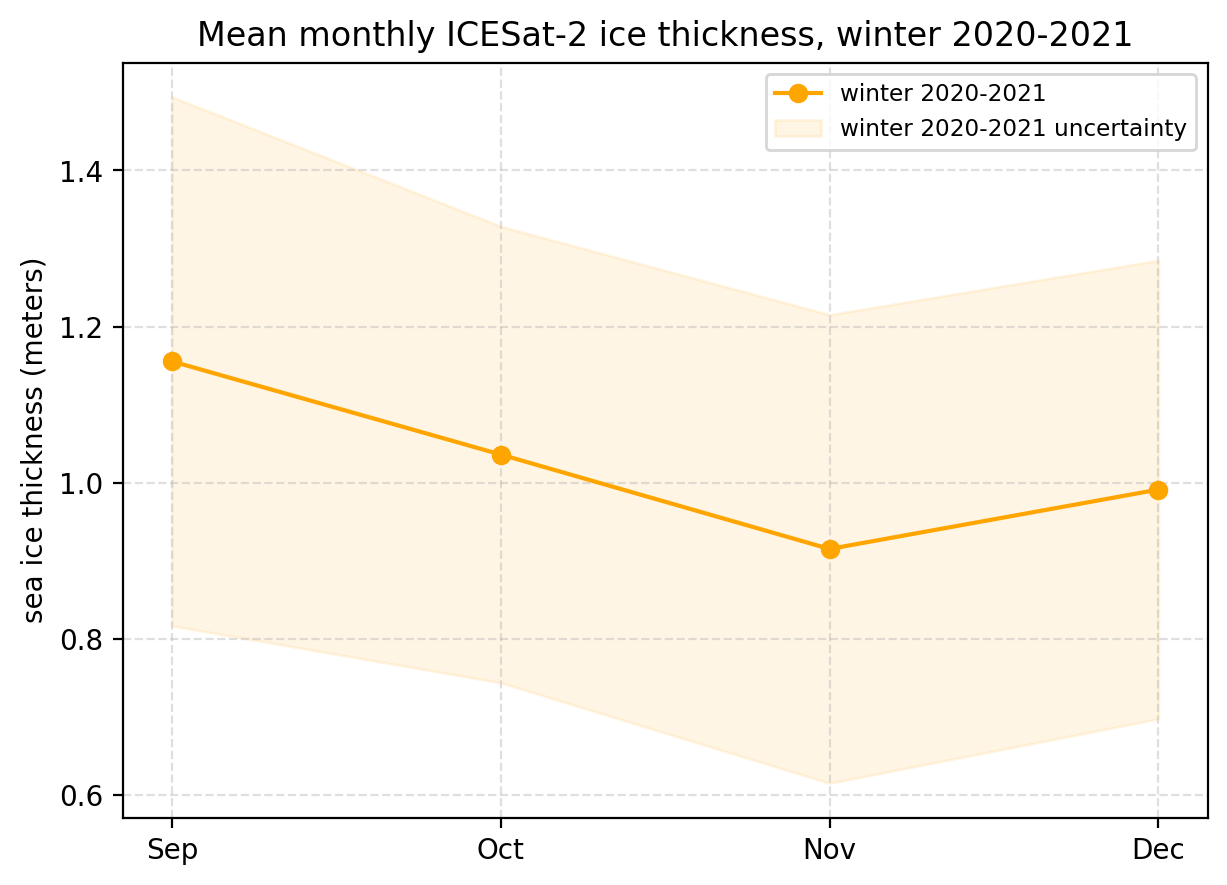

In [10]:
plot_winter_means(da=thickness, start_year="2020", end_year="2021", 
                  show_uncertainty=True, da_uncertainty=is2_ds["ice_thickness_unc"],  
                  title="Mean monthly ICESat-2 ice thickness, winter 2020-2021", 
                  colors = "orange") 